In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import sys
import networkx as nx
import os
import warnings
# matplotlib and seaborn for plotting

import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
ROOT_DATA_DIRECTORY = ROOT_PACKAGE_DIRECTORY + '/data'
GRAPH_DATABASE_PATH = ROOT_PACKAGE_DIRECTORY + '/data/graph/exp-reuse-same-workload.graph'
sys.path.append(ROOT_PACKAGE_DIRECTORY)

# Experiment Graph
from experiment_graph.execution_environment import ExecutionEnvironment as ee


# Suppress warnings
warnings.filterwarnings('ignore')
% matplotlib inline


try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

In [2]:
import os
import sys
import warnings
import hashlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# Experiment Graph
from sklearn.preprocessing import LabelEncoder

['.DS_Store', 'graph', 'home-credit-default-risk']
('Training data shape: ', (307511, 122))
('Testing data shape: ', (48744, 121))


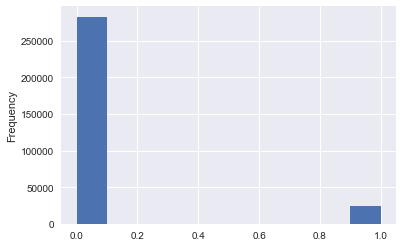

In [3]:
print(os.listdir(ROOT_DATA_DIRECTORY))
app_train = ee.load(ROOT_DATA_DIRECTORY + '/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape().data())
app_train.head().data()

app_test = ee.load(ROOT_DATA_DIRECTORY + '/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape().data())
app_test.head().data()

app_train['TARGET'].value_counts().data()

app_train['TARGET'].data().astype(int).plot.hist()

In [4]:
# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().data()

    mis_val_percent = 100 * mis_val / len(dataset.data())

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data()[1]) + " columns.\n"
                                                                          "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [5]:
app_train.dtypes().data().value_counts()

float64    65
int64      41
object     16
dtype: int64

In [6]:
app_train.select_dtypes('object').nunique().data()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [7]:
le = LabelEncoder()
le_count = 0

columns = app_train.select_dtypes('object').data().columns
for col in columns:
    # we are not using nunique because it discard nan
    if app_train[col].nunique(dropna=False).data() <= 2:
        model = app_train[col].fit_sk_model(le)

        transformed_train = model.transform_col(app_train[col], col)
        app_train = app_train.drop(col)
        app_train = app_train.add_columns(col, transformed_train)

        transformed_test = model.transform_col(app_test[col], col)
        app_test = app_test.drop(col)
        app_test = app_test.add_columns(col, transformed_test)

        # Keep track of how many columns were label encoded
        le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [8]:
app_train = app_train.onehot_encode()
app_test = app_test.onehot_encode()

print('Training Features shape: ', app_train.shape().data())
print('Testing Features shape: ', app_test.shape().data())

('Training Features shape: ', (307511, 243))
('Testing Features shape: ', (48744, 239))


In [9]:
train_labels = app_train['TARGET']
train_columns = app_train.data().columns
test_columns = app_test.data().columns
for c in train_columns:
    if c not in test_columns:
        app_train = app_train.drop(c)

app_train = app_train.add_columns('TARGET', train_labels)

In [10]:
print('Training Features shape: ', app_train.shape().data())
print('Testing Features shape: ', app_test.shape().data())

('Training Features shape: ', (307511, 240))
('Testing Features shape: ', (48744, 239))


Text(0.5,0,u'Days Employment')

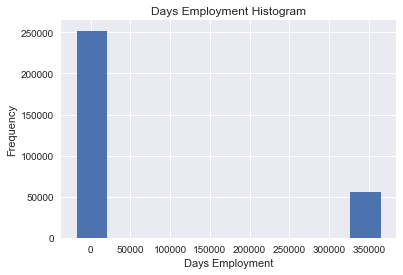

In [11]:
(app_train['DAYS_BIRTH'] / 365).describe().data()

app_train['DAYS_EMPLOYED'].describe().data()

app_train['DAYS_EMPLOYED'].data().plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

In [12]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean().data()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean().data()))
print('There are %d anomalous days of employment' % anom.shape().data()[0])

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [13]:
days_employed_anom = app_train['DAYS_EMPLOYED'] == 365243
app_train = app_train.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_train['DAYS_EMPLOYED'].replace({365243: np.nan})
app_train = app_train.drop('DAYS_EMPLOYED')
app_train = app_train.add_columns('DAYS_EMPLOYED', temp)

Text(0.5,0,u'Days Employment')

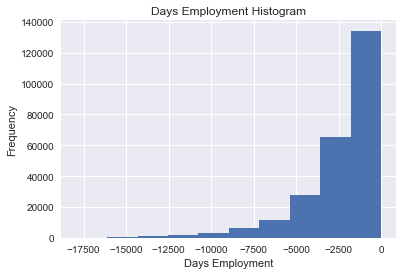

In [14]:
app_train["DAYS_EMPLOYED"].data().plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment')

In [15]:
days_employed_anom = app_test["DAYS_EMPLOYED"] == 365243
app_test = app_test.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_test['DAYS_EMPLOYED'].replace({365243: np.nan})
app_test = app_test.drop('DAYS_EMPLOYED')
app_test = app_test.add_columns('DAYS_EMPLOYED', temp)
print('There are %d anomalies in the test data out of %d entries'
      % (app_test['DAYS_EMPLOYED_ANOM'].sum().data(),
         app_test.shape().data()[0]))

There are 9274 anomalies in the test data out of 48744 entries


In [16]:
# correlations = app_train.corr().data()
# top = correlations['TARGET'].sort_values()
# # Display correlations
# print('Most Positive Correlations:\n', top.tail(15))
# print('\nMost Negative Correlations:\n', top.head(15))

In [17]:
abs_age = app_train['DAYS_BIRTH'].abs()
app_train = app_train.drop('DAYS_BIRTH')
app_train = app_train.add_columns('DAYS_BIRTH', abs_age)
app_train['DAYS_BIRTH'].corr(app_train['TARGET']).data()

-0.078239308309827088

Text(0,0.5,u'Count')

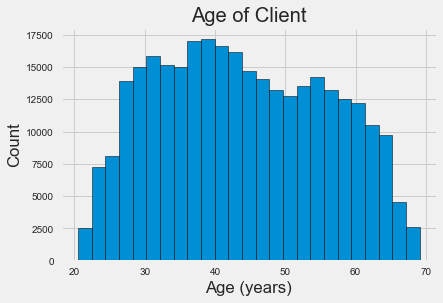

In [18]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist((app_train['DAYS_BIRTH'] / 365).data(), edgecolor='k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

In [19]:
# plt.figure(figsize=(10, 8))
# # KDE plot of loans that were repaid on time
# sns.kdeplot((app_train[app_train['TARGET'] == 0]['DAYS_BIRTH'] / 365).data(), label='target == 0')
# # KDE plot of loans which were not repaid on time
# sns.kdeplot((app_train[app_train['TARGET'] == 1]['DAYS_BIRTH'] / 365).data(), label='target == 1')
# # Labeling of plot
# plt.xlabel('Age (years)')
# plt.ylabel('Density')
# plt.title('Distribution of Ages')

In [20]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
years_birth = age_data['DAYS_BIRTH'] / 365
age_data = age_data.add_columns('YEARS_BIRTH', years_birth)
binned = age_data['YEARS_BIRTH'].binning(20, 70, 11)
binned.setname('YEARS_BINNED')
age_data = age_data.add_columns('YEARS_BINNED', binned)
age_data.head(10).data()

age_groups = age_data.groupby('YEARS_BINNED').mean()

Text(0.5,1,u'Failure to Repay by Age Group')

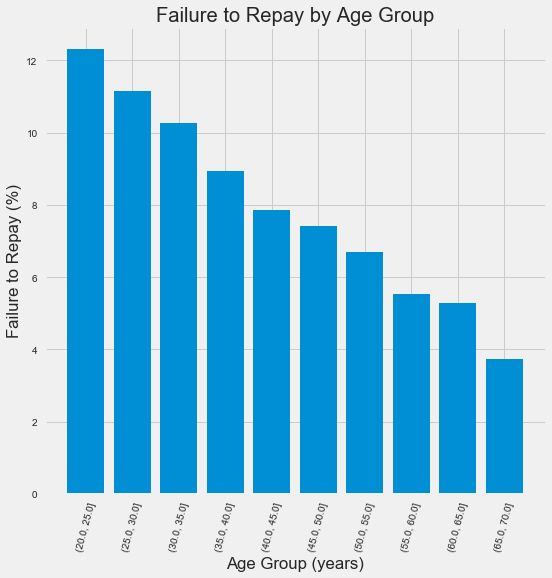

In [21]:
plt.figure(figsize=(8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.data().index.astype(str), age_groups.data()['TARGET'] * 100)

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

In [22]:
# ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
# ext_data_corrs = ext_data.corr().data()

# plt.figure(figsize=(8, 6))

# # Heatmap of correlations
# sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
# plt.title('Correlation Heatmap')

In [23]:
# plt.figure(figsize=(10, 12))

# # iterate through the sources
# for i, column in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
#     # create a new subplot for each source
#     plt.subplot(3, 1, i + 1)
#     # plot repaid loans
#     source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 0]
#     sns.kdeplot(source_data[app_train[column].notna()][column].data(), label='target == 0')
#     # plot loans that were not repaid
#     source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 1]
#     sns.kdeplot(source_data[app_train[column].notna()][column].data(), label='target == 1')

#     # Label the plots
#     plt.title('Distribution of %s by Target Value' % column)
#     plt.xlabel('%s' % column)
#     plt.ylabel('Density')

# plt.tight_layout(h_pad=2.5)

In [24]:
# # Copy the data for plotting
# plot_data = ext_data.drop('DAYS_BIRTH')

# # Add in the age of the client in years
# plot_data = plot_data.add_columns('YEARS_BIRTH', age_data['YEARS_BIRTH'])
# # Drop na values and limit to first 100000 rows
# plot_data = plot_data.head(100000).dropna()

# # Create the pair grid object
# grid = sns.PairGrid(data=plot_data.data(), size=3, diag_sharey=False,
#                     hue='TARGET',
#                     vars=[x for x in list(plot_data.data().columns) if x != 'TARGET'])

# # Upper is a scatter plot
# grid.map_upper(plt.scatter, alpha=0.2)

# # Diagonal is a histogram
# grid.map_diag(sns.kdeplot)

# # Bottom is density plot
# grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

# plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

In [25]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Need to impute missing values
imputer_model = poly_features.fit_sk_model(imputer)
poly_features = imputer_model.transform(poly_features)
poly_features_test = imputer_model.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=3)

# Train the polynomial features
poly_transformer_model = poly_features.fit_sk_model(poly_transformer)

poly_features = poly_transformer_model.transform(poly_features)
poly_features_test = poly_transformer_model.transform(poly_features_test)

new_names = poly_transformer_model.data().get_feature_names(input_features=[
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'
])

# Call manually before meta data update
poly_features.set_columns(new_names)

In [26]:
# Add in the target
poly_features = poly_features.add_columns('TARGET', poly_target)

# Find the correlations with the target
poly_corrs = poly_features.corr().data()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))
poly_features_test.set_columns(new_names)

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [27]:
# Merge polynomial features into training dataframe
poly_features = poly_features.add_columns('SK_ID_CURR', app_train['SK_ID_CURR'])
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

In [28]:
# Merge polnomial features into testing dataframe
poly_features_test = poly_features_test.add_columns('SK_ID_CURR', app_test['SK_ID_CURR'])
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

In [29]:
# Align the dataframes
train_columns = app_train_poly.data().columns
test_columns = app_test_poly.data().columns
for c in train_columns:
    if c not in test_columns:
        app_train_poly = app_train_poly.drop(c)

In [30]:
# Print out the new shapes
print('Training data with polynomial features shape: ',
      app_train_poly.shape().data())
print('Testing data with polynomial features shape:  ',
      app_test_poly.shape().data())

('Training data with polynomial features shape: ', (307511, 275))
('Testing data with polynomial features shape:  ', (48744, 275))


In [31]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain = app_train_domain.add_columns(
    'CREDIT_INCOME_PERCENT',
    app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns(
    'ANNUITY_INCOME_PERCENT',
    app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns(
    'CREDIT_TERM',
    app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT'])
app_train_domain = app_train_domain.add_columns(
    'DAYS_EMPLOYED_PERCENT',
    app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH'])

app_test_domain = app_test_domain.add_columns(
    'CREDIT_INCOME_PERCENT',
    app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns(
    'ANNUITY_INCOME_PERCENT',
    app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns(
    'CREDIT_TERM',
    app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT'])
app_test_domain = app_test_domain.add_columns(
    'DAYS_EMPLOYED_PERCENT',
    app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH'])

In [32]:
# plt.figure(figsize=(12, 20))
# # iterate through the new features
# for i, column in enumerate([
#     'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM',
#     'DAYS_EMPLOYED_PERCENT'
# ]):
#     # create a new subplot for each source
#     plt.subplot(4, 1, i + 1)
#     # plot repaid loans
#     negative = app_train_domain[[column, 'TARGET']][app_train['TARGET'] == 0]
#     sns.kdeplot(
#         negative[app_train_domain[column].notna()][column].data(),
#         label='target == 0')
#     # plot loans that were not repaid
#     positive = app_train_domain[[column, 'TARGET']][app_train['TARGET'] == 1]
#     sns.kdeplot(
#         positive[app_train_domain[column].notna()][column].data(),
#         label='target == 1')

#     # Label the plots
#     plt.title('Distribution of %s by Target Value' % column)
#     plt.xlabel('%s' % column)
#     plt.ylabel('Density')

# plt.tight_layout(h_pad=2.5)

In [33]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
columns = app_train.data().columns
if 'TARGET' in columns:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()


# Feature names
features = list(train.data().columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
sk_imputer = Imputer(strategy='median')

# Scale each feature to 0-1
sk_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
imputer = train.fit_sk_model(sk_imputer)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler = train.fit_sk_model(sk_scaler)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape().data())
print('Testing data shape: ', test.shape().data())

('Training data shape: ', (307511, 240))
('Testing data shape: ', (48744, 240))


In [34]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
sk_log_reg = LogisticRegression(C=0.0001)

# Train on the training data
log_reg = train.fit_sk_model_with_labels(sk_log_reg, train_labels)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[1]

# Submission data
log_reg_pred.setname('TARGET')
submit = app_test['SK_ID_CURR'].concat(log_reg_pred)
submit.head().data()

,SK_ID_CURR,TARGET
0,100001,0.127735
1,100005,0.155207
2,100013,0.071158
3,100028,0.127554
4,100038,0.028848


In [51]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
sk_random_forest = RandomForestClassifier(n_estimators=5, random_state=50, verbose=1, n_jobs=-1)

# Train on the training data
random_forest = train.fit_sk_model_with_labels(sk_random_forest, train_labels)

# Extract feature importances
feature_importances = random_forest.feature_importances(features)

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[1]

# Score = 0.678
# Submission dataframe
predictions.setname('TARGET')
submit = app_test['SK_ID_CURR'].concat(predictions)
submit.head().data()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


,SK_ID_CURR,TARGET
0,100001,0.0
1,100005,0.6
2,100013,0.6
3,100028,0.6
4,100038,0.2


In [36]:
# poly_features_names = list(app_train_poly.data().columns)

# # Impute the polynomial features
# sk_imputer = Imputer(strategy='median')
# imputer = app_train_poly.fit_sk_model(sk_imputer)

# poly_features = imputer.transform(app_train_poly)
# poly_features_test = imputer.transform(app_test_poly)

# # Scale the polynomial features
# sk_scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = poly_features.fit_sk_model(sk_scaler)

# poly_features = scaler.transform(poly_features)
# poly_features_test = scaler.transform(poly_features_test)

# sk_random_forest_poly = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
# random_forest_poly = poly_features.fit_sk_model_with_labels(sk_random_forest_poly, train_labels)

# # Make predictions on the test data
# predictions = random_forest_poly.predict_proba(poly_features_test)[1]

# # Score = 0.678
# # Submission dataframe
# predictions.setname('TARGET')
# submit = app_test['SK_ID_CURR'].concat(predictions)
# submit.head().data()

In [37]:
# app_train_domain = app_train_domain.drop(columns='TARGET')

# domain_features_names = list(app_train_domain.data().columns)

# # Impute the domainnomial features
# sk_imputer = Imputer(strategy='median')
# imputer = app_train_domain.fit_sk_model(sk_imputer)

# domain_features = imputer.transform(app_train_domain)
# domain_features_test = imputer.transform(app_test_domain)

# # Scale the domainnomial features
# sk_scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = domain_features.fit_sk_model(sk_scaler)

# domain_features = scaler.transform(domain_features)
# domain_features_test = scaler.transform(domain_features_test)

# # Train on the training data
# sk_random_forest_domain = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
# random_forest_domain = domain_features.fit_sk_model_with_labels(sk_random_forest_domain, train_labels)

# # Extract feature importances
# feature_importances_domain = random_forest_domain.feature_importances(domain_features_names)

# # Make predictions on the test data
# predictions = random_forest_domain.predict_proba(domain_features_test)[1]

# # Score = 0.678
# # Make a submission dataframe
# predictions.setname('TARGET')
# submit = app_test['SK_ID_CURR'].concat(predictions)
# submit.head().data()

NameError: name 'RandomForestClassifier' is not defined

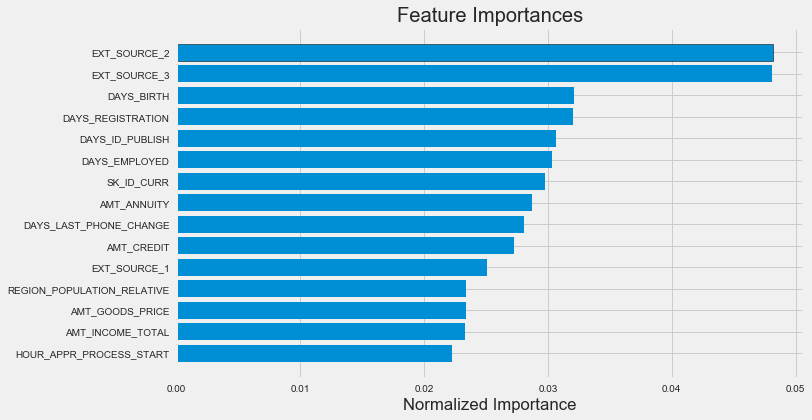

In [53]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending=False)

    # Normalize the feature importances to add up to one
    df = df.add_columns('importance_normalized', df['importance'] / df['importance'].sum().data())

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.data().index[:15]))),
            df['importance_normalized'].data().head(15),
            align='center', edgecolor='k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.data().index[:15]))))
    ax.set_yticklabels(df['feature'].data().head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance');
    plt.title('Feature Importances')
    plt.show()

    return df


# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)